#Machine Learning Approaches for Early Detection of Parkinson's Disease

## Attribute Information


- **name**: ASCII subject name and recording number
- **MDVP:Fo(Hz)**: Average vocal fundamental frequency
- **MDVP:Fhi(Hz)**: Maximum vocal fundamental frequency
- **MDVP:Flo(Hz)**: Minimum vocal fundamental frequency
- **MDVP:Jitter(%)**, **MDVP:Jitter(Abs)**, **MDVP:RAP**, **MDVP:PPQ**, **Jitter:DDP**: Several measures of variation in fundamental frequency
- **MDVP:Shimmer**, **MDVP:Shimmer(dB)**, **Shimmer:APQ3**, **Shimmer:APQ5**, **MDVP:APQ**, **Shimmer:DDA**: Several measures of variation in amplitude
- **NHR**, **HNR**: Two measures of the ratio of noise to tonal components in the voice
- **status**: The health status of the subject:
  - **1**: Parkinson's disease
  - **0**: Healthy
- **RPDE**, **D2**: Two nonlinear dynamical complexity measures
- **DFA**: Signal fractal scaling exponent
- **spread1**, **spread2**, **PPE**: Three nonlinear measures of fundamental frequency variation

##Data Inspecting and Preprocessing

In [ ]:
!pip install catboost

In [ ]:
!pip install logitboost

In [ ]:
!pip install dask[dataframe]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from logitboost import LogitBoost
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving parkinsons.data to parkinsons (2).data


In [ ]:
# Loading the dataset
file_path = 'parkinsons.data'
df = pd.read_csv(file_path)
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MDVP:Fo(Hz),195.0,154.228641,41.390065,88.333000,117.572000,148.790000,182.769000,260.105000
MDVP:Fhi(Hz),195.0,197.104918,91.491548,102.145000,134.862500,175.829000,224.205500,592.030000
MDVP:Flo(Hz),195.0,116.324631,43.521413,65.476000,84.291000,104.315000,140.018500,239.170000
MDVP:Jitter(%),195.0,0.006220,0.004848,0.001680,0.003460,0.004940,0.007365,0.033160
MDVP:Jitter(Abs),195.0,0.000044,0.000035,0.000007,0.000020,0.000030,0.000060,0.000260
MDVP:RAP,195.0,0.003306,0.002968,0.000680,0.001660,0.002500,0.003835,0.021440
MDVP:PPQ,195.0,0.003446,0.002759,0.000920,0.001860,0.002690,0.003955,0.019580
Jitter:DDP,195.0,0.009920,0.008903,0.002040,0.004985,0.007490,0.011505,0.064330
MDVP:Shimmer,195.0,0.029709,0.018857,0.009540,0.016505,0.022970,0.037885,0.119080
MDVP:Shimmer(dB),195.0,0.282251,0.194877,0.085000,0.148500,0.221000,0.350000,1.302000


In [ ]:
df.isnull().sum()

,0
name,0
MDVP:Fo(Hz),0
MDVP:Fhi(Hz),0
MDVP:Flo(Hz),0
MDVP:Jitter(%),0
MDVP:Jitter(Abs),0
MDVP:RAP,0
MDVP:PPQ,0
Jitter:DDP,0
MDVP:Shimmer,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE'],
      dtype='object')

##Exploratory Data Analysis (EDA)


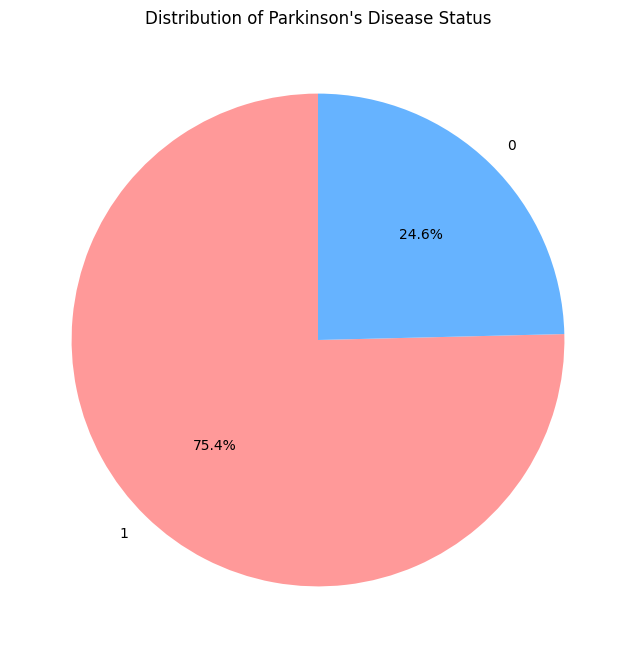

In [ ]:
# Plot a pie chart for the 'status' feature
status_counts = df['status'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribution of Parkinson\'s Disease Status')
plt.show()

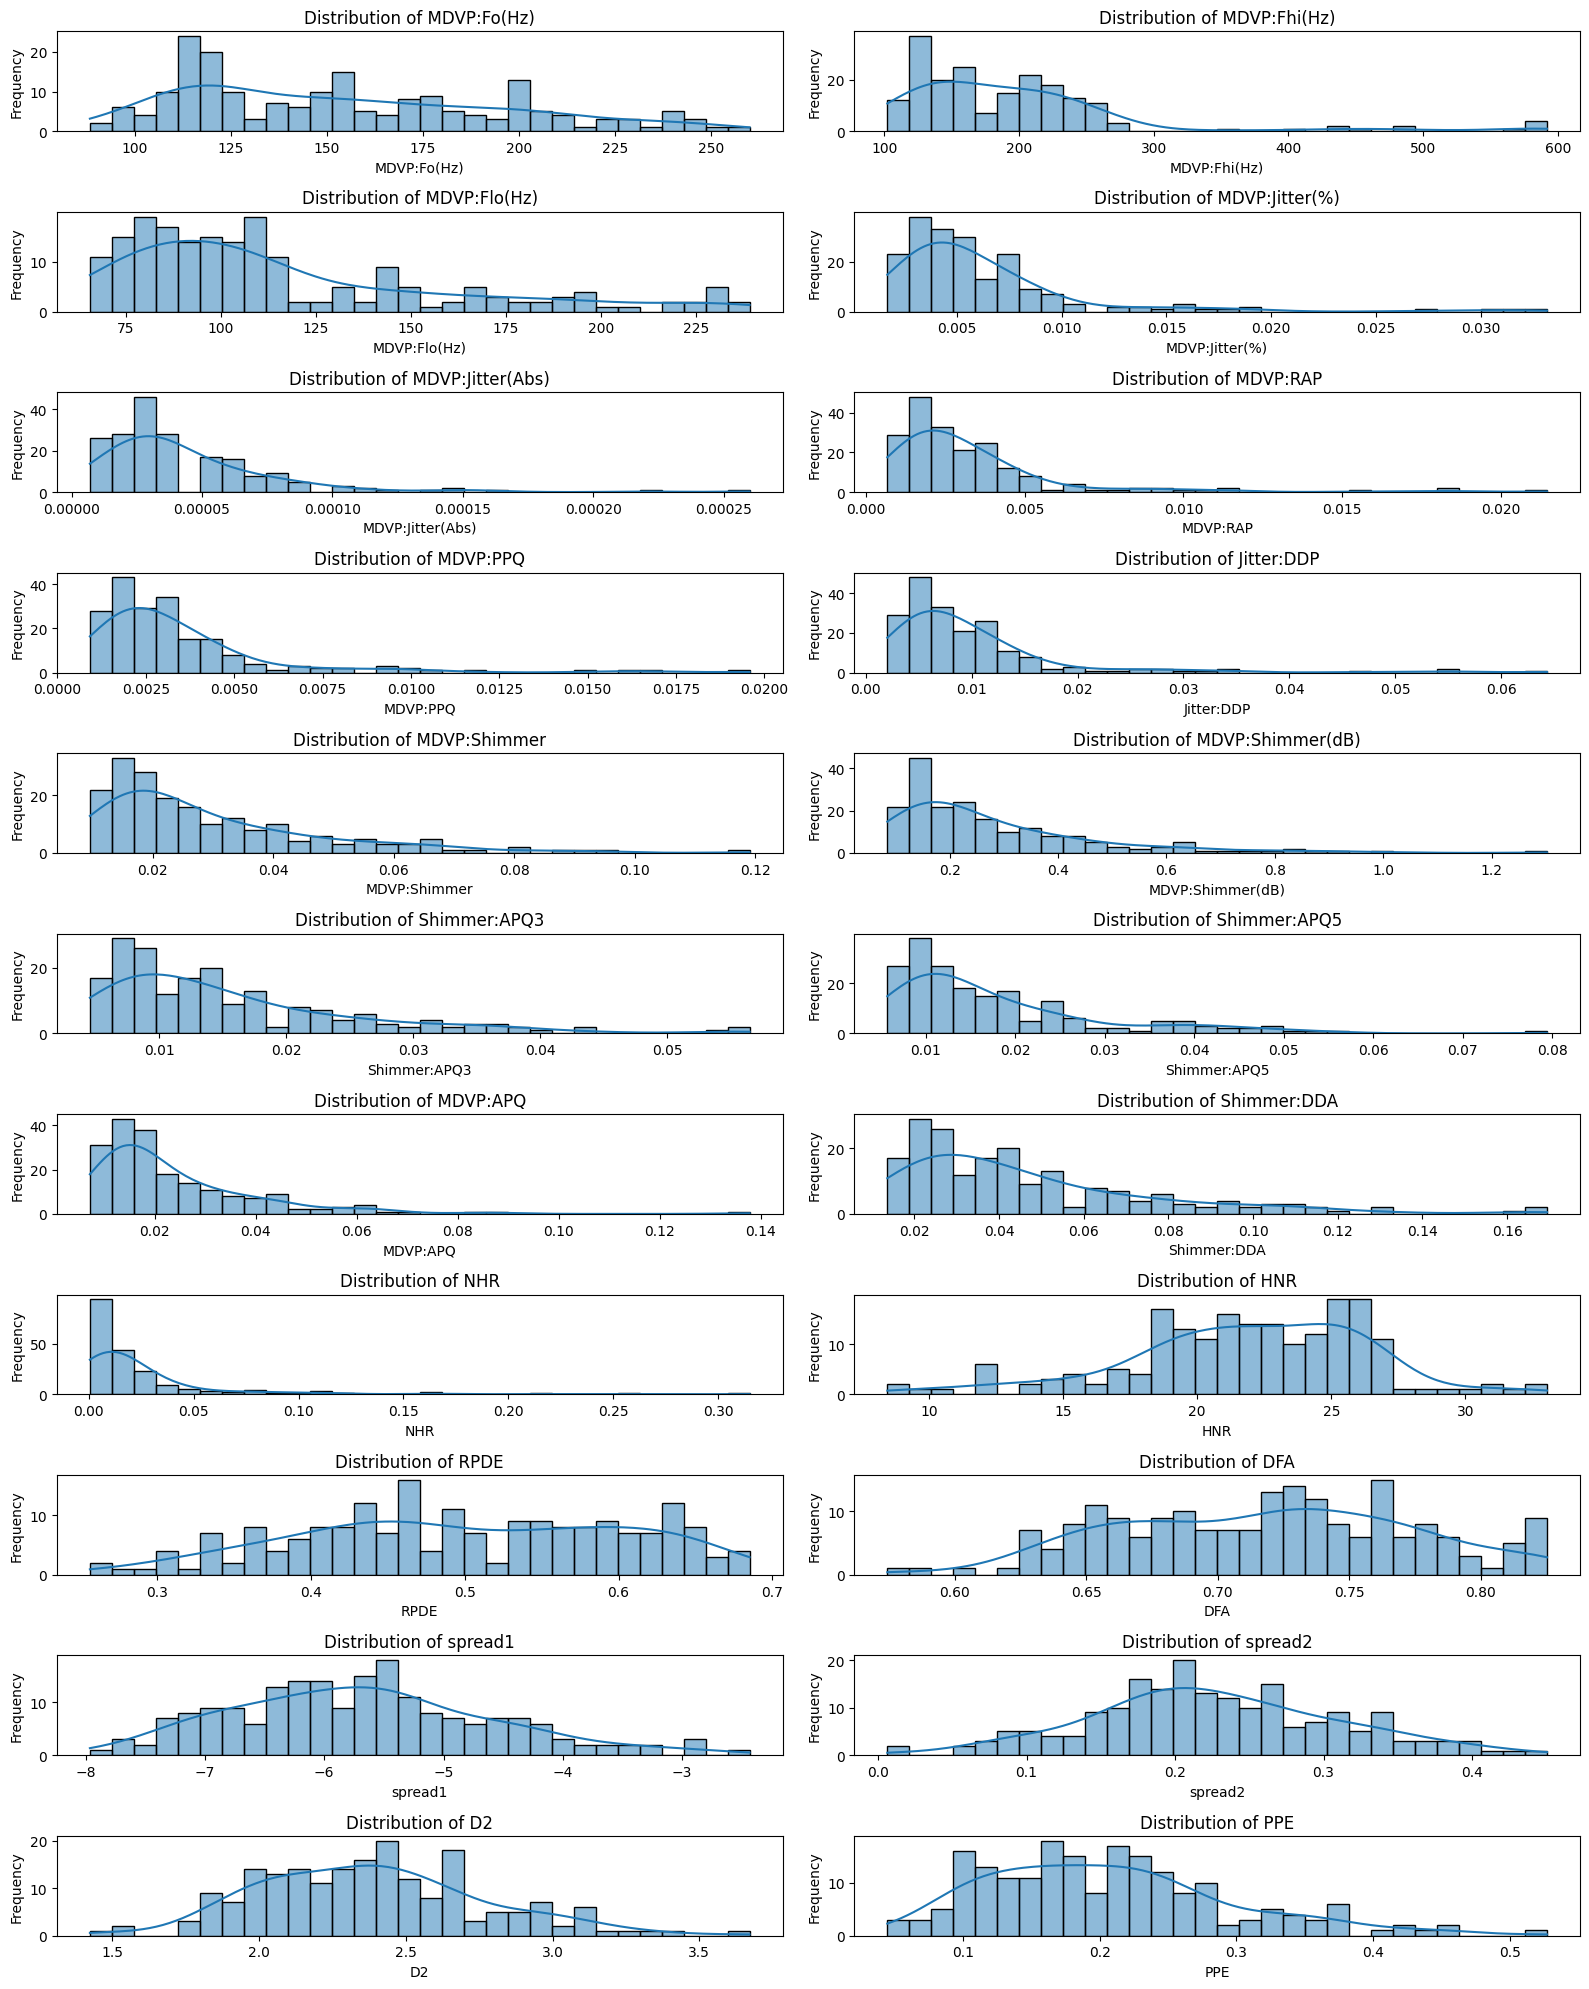

In [ ]:
# Define key features to plot
key_features = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE']

# Plot distribution of key features
plt.figure(figsize=(16, 20))
for i, feature in enumerate(key_features, 1):
    plt.subplot(11, 2, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

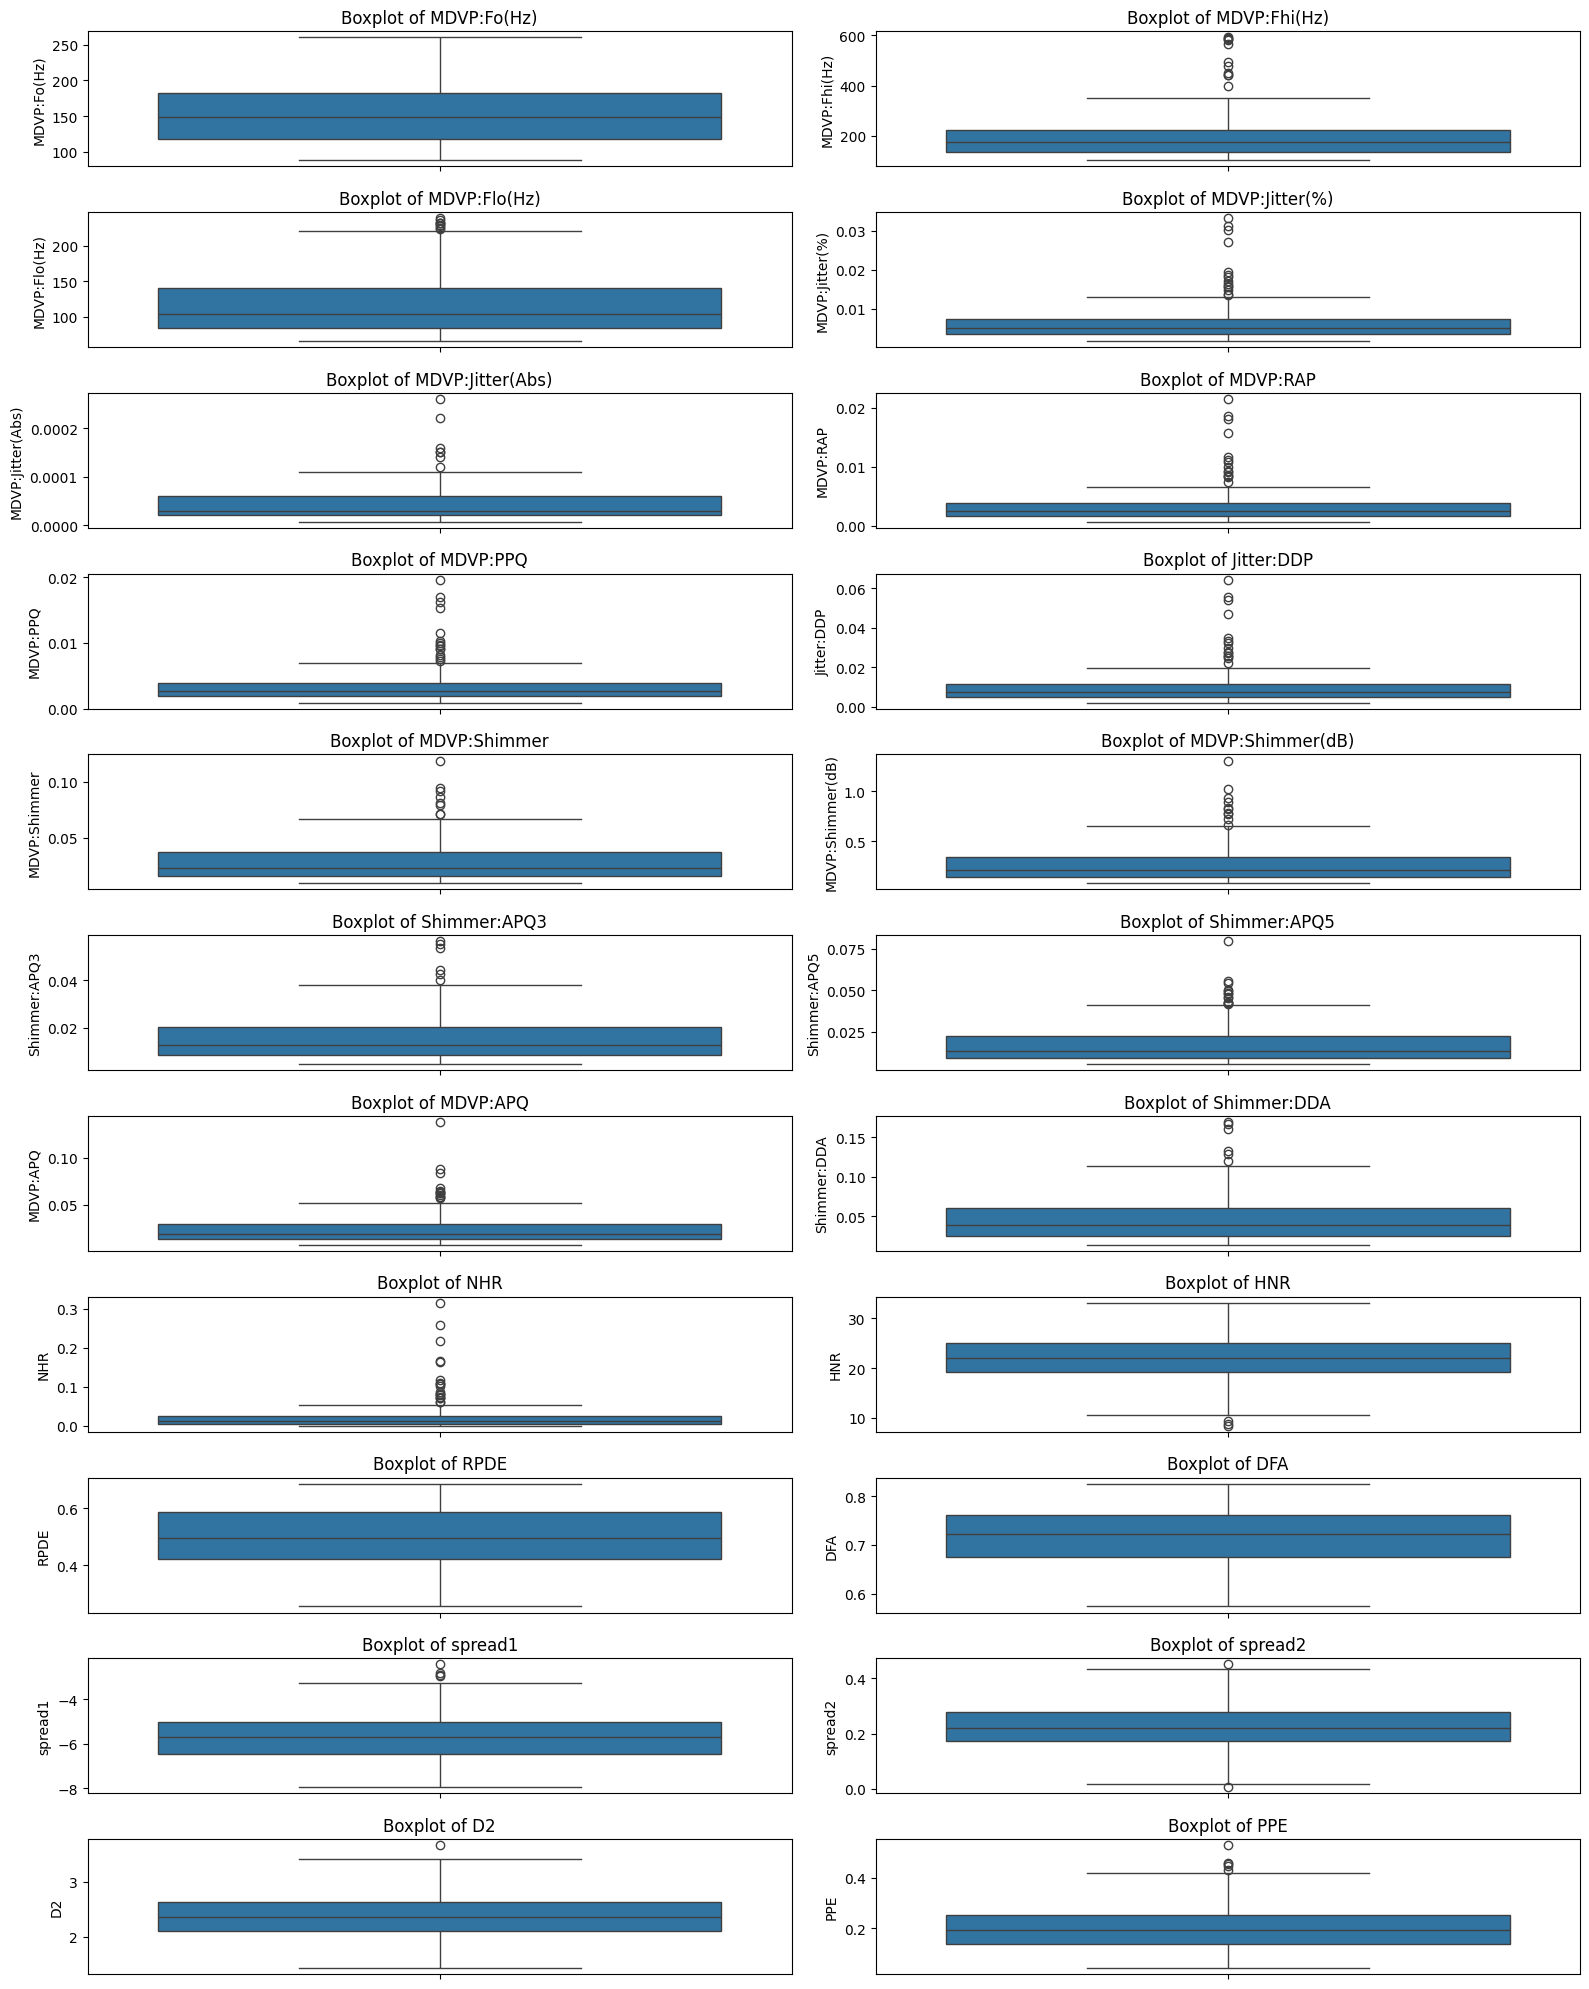

In [ ]:
# Plot boxplots for key features to detect outliers
plt.figure(figsize=(16, 20))
for i, feature in enumerate(key_features, 1):
    plt.subplot(11, 2, i)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

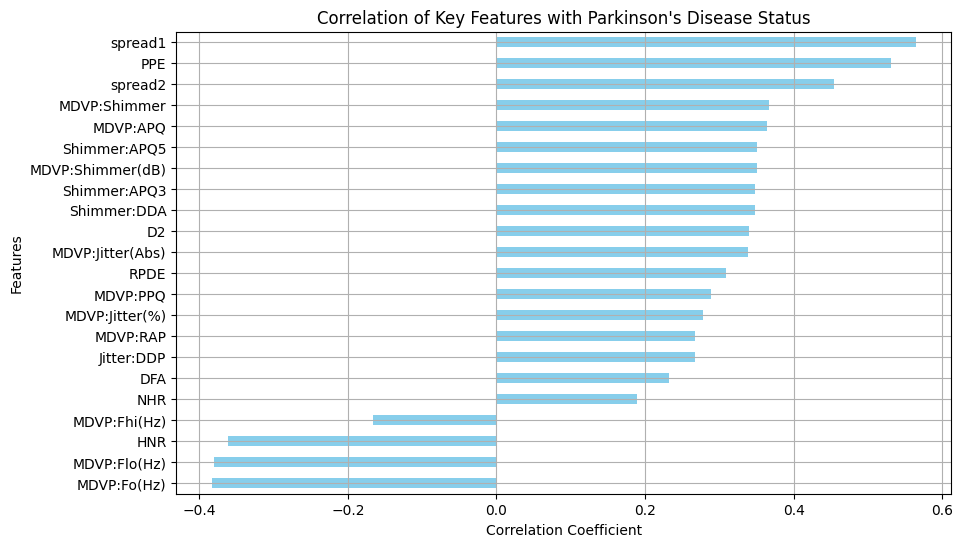

In [ ]:
# Correlation analysis between key features and 'status'
correlations_with_status = df[key_features].corrwith(df['status'])

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
correlations_with_status.sort_values().plot(kind='barh', color='skyblue')
plt.title('Correlation of Key Features with Parkinson\'s Disease Status')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True)
plt.show()

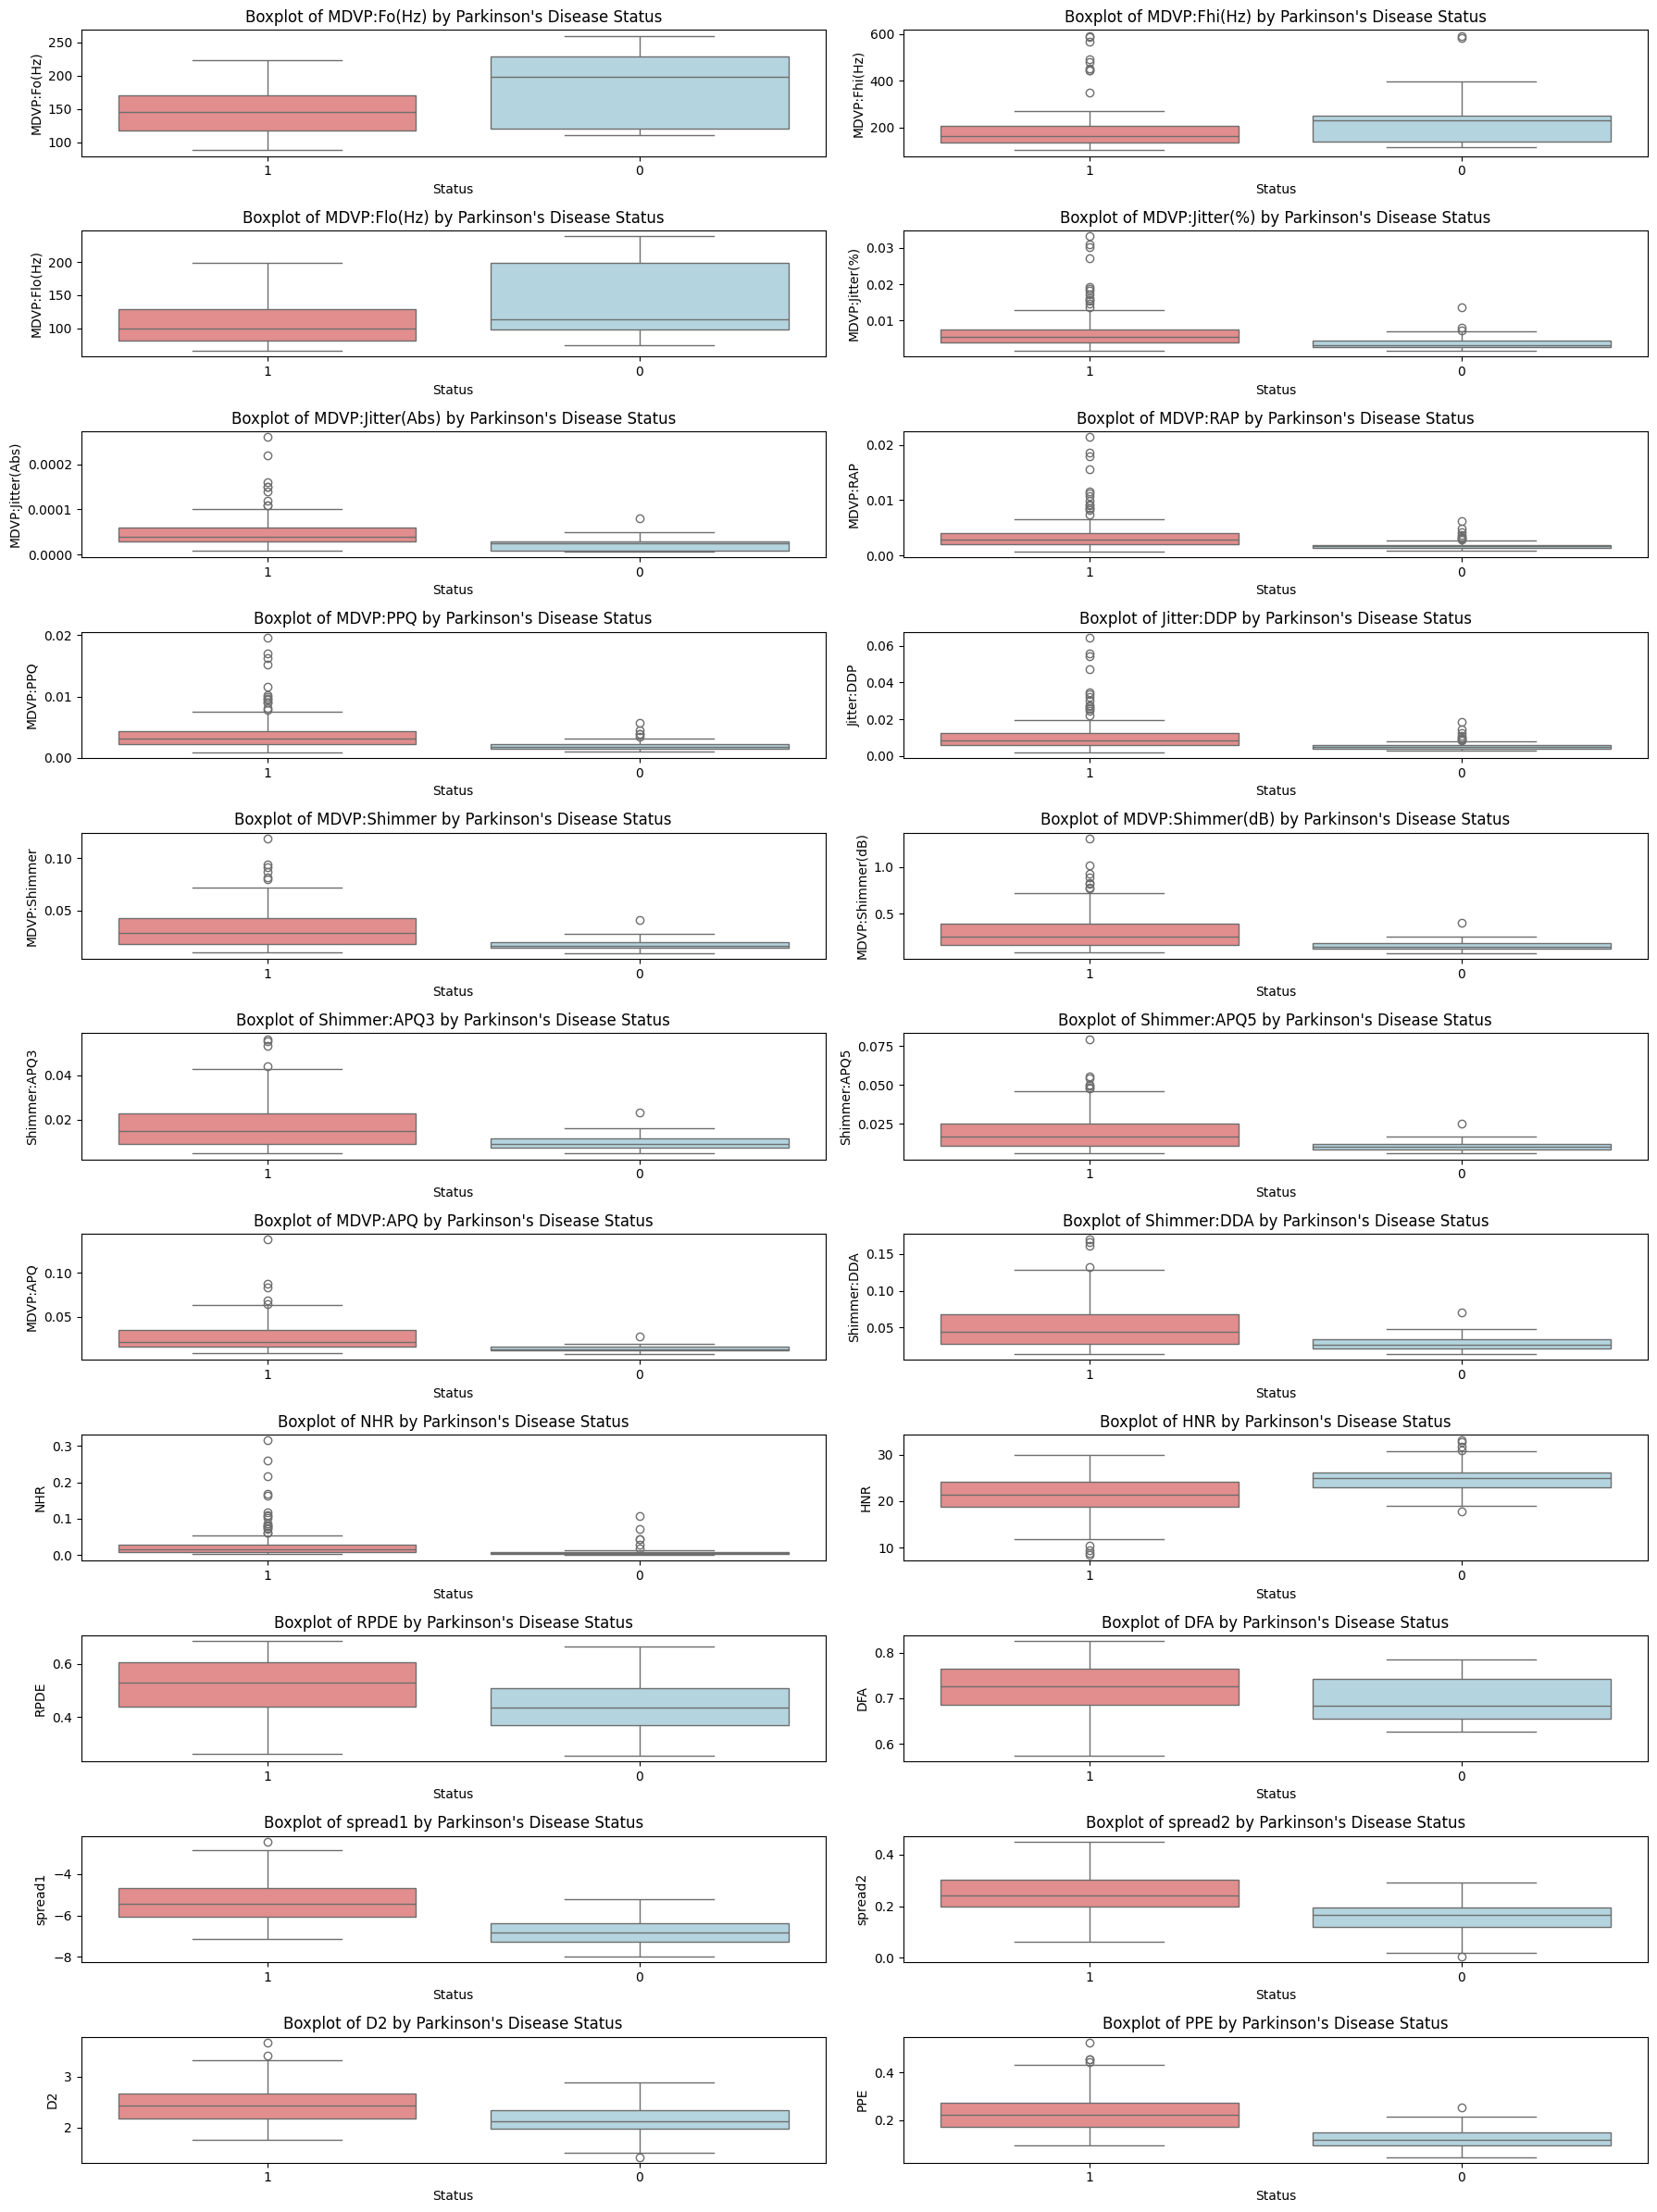

In [ ]:
# Convert the 'status' column to string type to match the palette keys
df['status_str'] = df['status'].astype(str)

# Plot boxplots with corrected palette keys as strings
plt.figure(figsize=(18, 24))
for i, feature in enumerate(key_features, 1):
    plt.subplot(11, 2, i)
    sns.boxplot(x='status_str', y=feature, data=df, palette={'0': "lightblue", '1': "lightcoral"})
    plt.title(f'Boxplot of {feature} by Parkinson\'s Disease Status')
    plt.xlabel('Status')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


##Predictive Modeling

###Model Training

In [ ]:
df.columns

Index(['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA',
       'spread1', 'spread2', 'D2', 'PPE', 'status_str'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [ ]:
# Drop unnecessary columns
df = df.drop(columns=['status_str', 'name'])

In [ ]:
# Split data into features (X) and target (y)
X = df.drop(columns=['status'])
y = df['status']

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data and transform X
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the scaled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# List of models to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss'),
    "LightGBM": lgb.LGBMClassifier(),
    "CatBoost": cb.CatBoostClassifier(verbose=0),
    "LogitBoost": LogitBoost()
}


In [ ]:
from sklearn.metrics import confusion_matrix
# Function to train and evaluate models
def train_and_evaluate(models, X_train, X_test, y_train, y_test):
    results = {}
    predictions = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')

        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        predictions[name] = y_pred

        print(f"{name} results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}\n")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    return results, predictions

###Model Evaluation

Logistic Regression results:
Accuracy: 0.8718
Precision: 0.7879
Recall: 0.7545
F1 Score: 0.7692



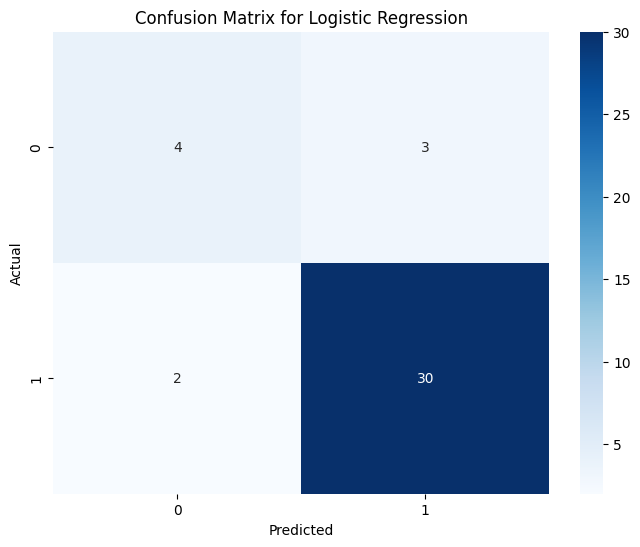

Decision Tree results:
Accuracy: 0.9231
Precision: 0.8864
Recall: 0.8415
F1 Score: 0.8615



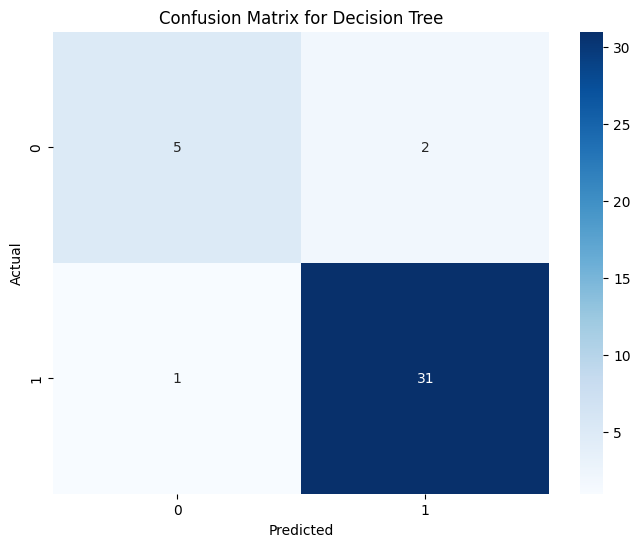

Random Forest results:
Accuracy: 0.9487
Precision: 0.9706
Recall: 0.8571
F1 Score: 0.9015



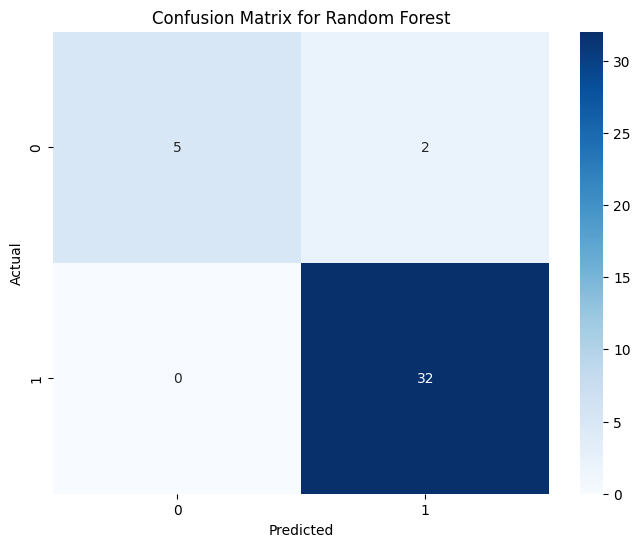

AdaBoost results:
Accuracy: 0.7949
Precision: 0.6722
Recall: 0.7076
F1 Score: 0.6855



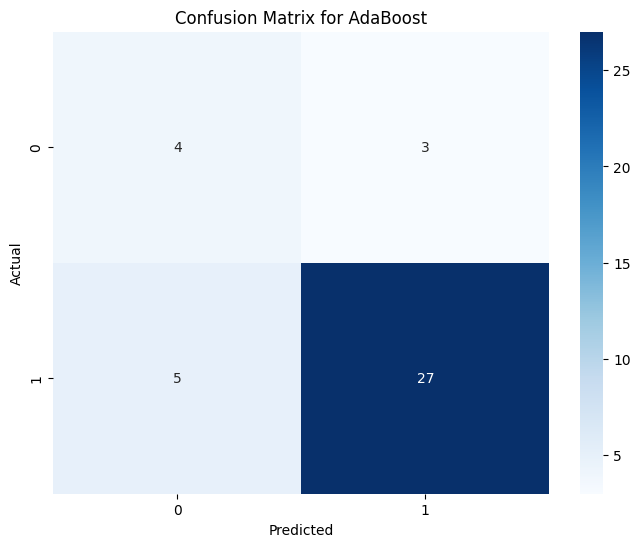

Gradient Boosting results:
Accuracy: 0.9231
Precision: 0.8864
Recall: 0.8415
F1 Score: 0.8615



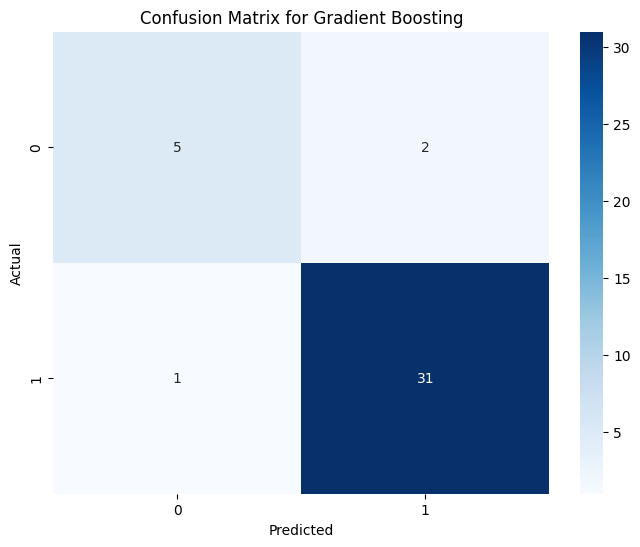

XGBoost results:
Accuracy: 0.9231
Precision: 0.8864
Recall: 0.8415
F1 Score: 0.8615



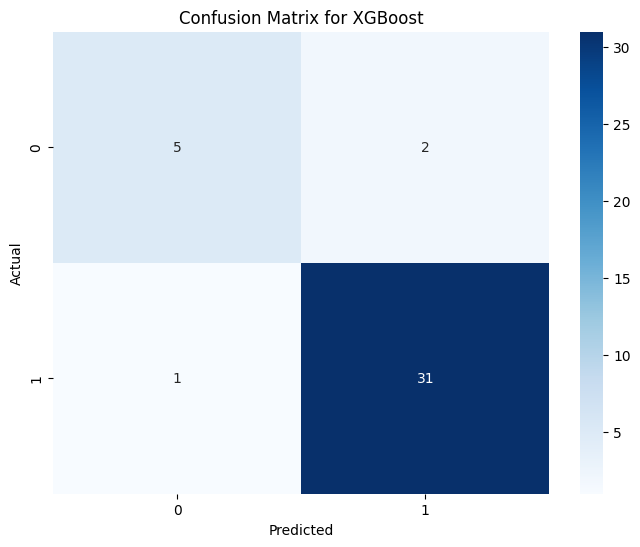

[LightGBM] [Info] Number of positive: 115, number of negative: 115
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1661
[LightGBM] [Info] Number of data points in the train set: 230, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

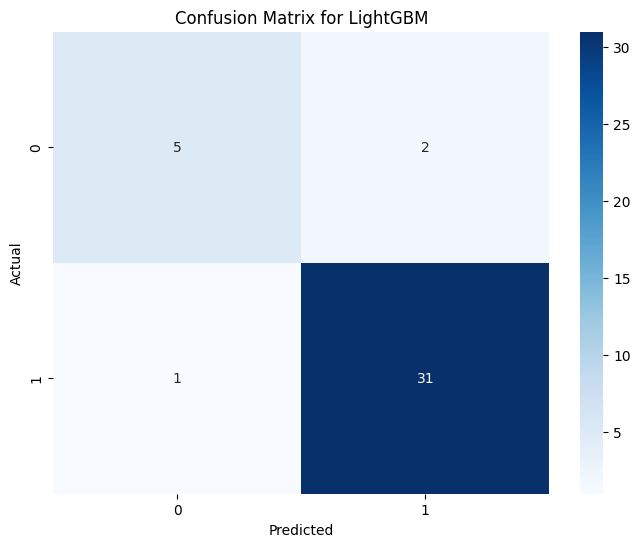

CatBoost results:
Accuracy: 0.9487
Precision: 0.9706
Recall: 0.8571
F1 Score: 0.9015



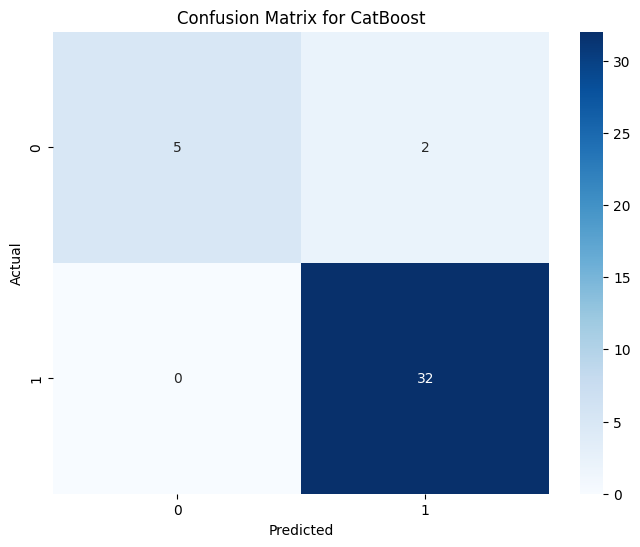

LogitBoost results:
Accuracy: 0.8974
Precision: 0.8259
Recall: 0.8259
F1 Score: 0.8259



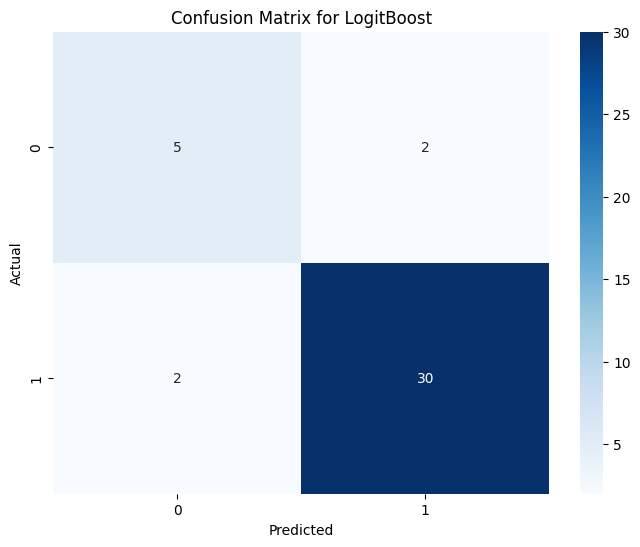

In [ ]:
# Train and evaluate the models
results, predictions = train_and_evaluate(models, X_train, X_test, y_train, y_test)

In [ ]:
# Display results in a table format
results_df = pd.DataFrame(results)
results_df

,Logistic Regression,Decision Tree,Random Forest,AdaBoost,Gradient Boosting,XGBoost,LightGBM,CatBoost,LogitBoost
accuracy,0.871795,0.923077,0.948718,0.794872,0.923077,0.923077,0.923077,0.948718,0.897436
precision,0.787879,0.886364,0.970588,0.672222,0.886364,0.886364,0.886364,0.970588,0.825893
recall,0.754464,0.841518,0.857143,0.707589,0.841518,0.841518,0.841518,0.857143,0.825893
f1_score,0.769231,0.861538,0.901515,0.685484,0.861538,0.861538,0.861538,0.901515,0.825893


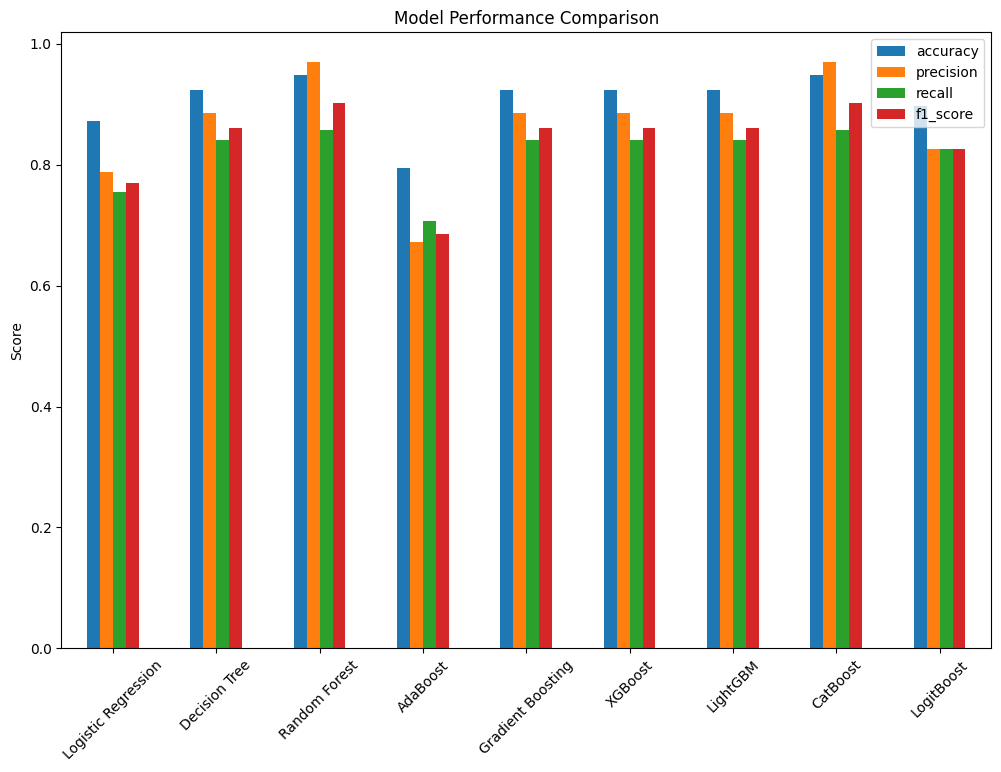

In [ ]:
# Plotting the results
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

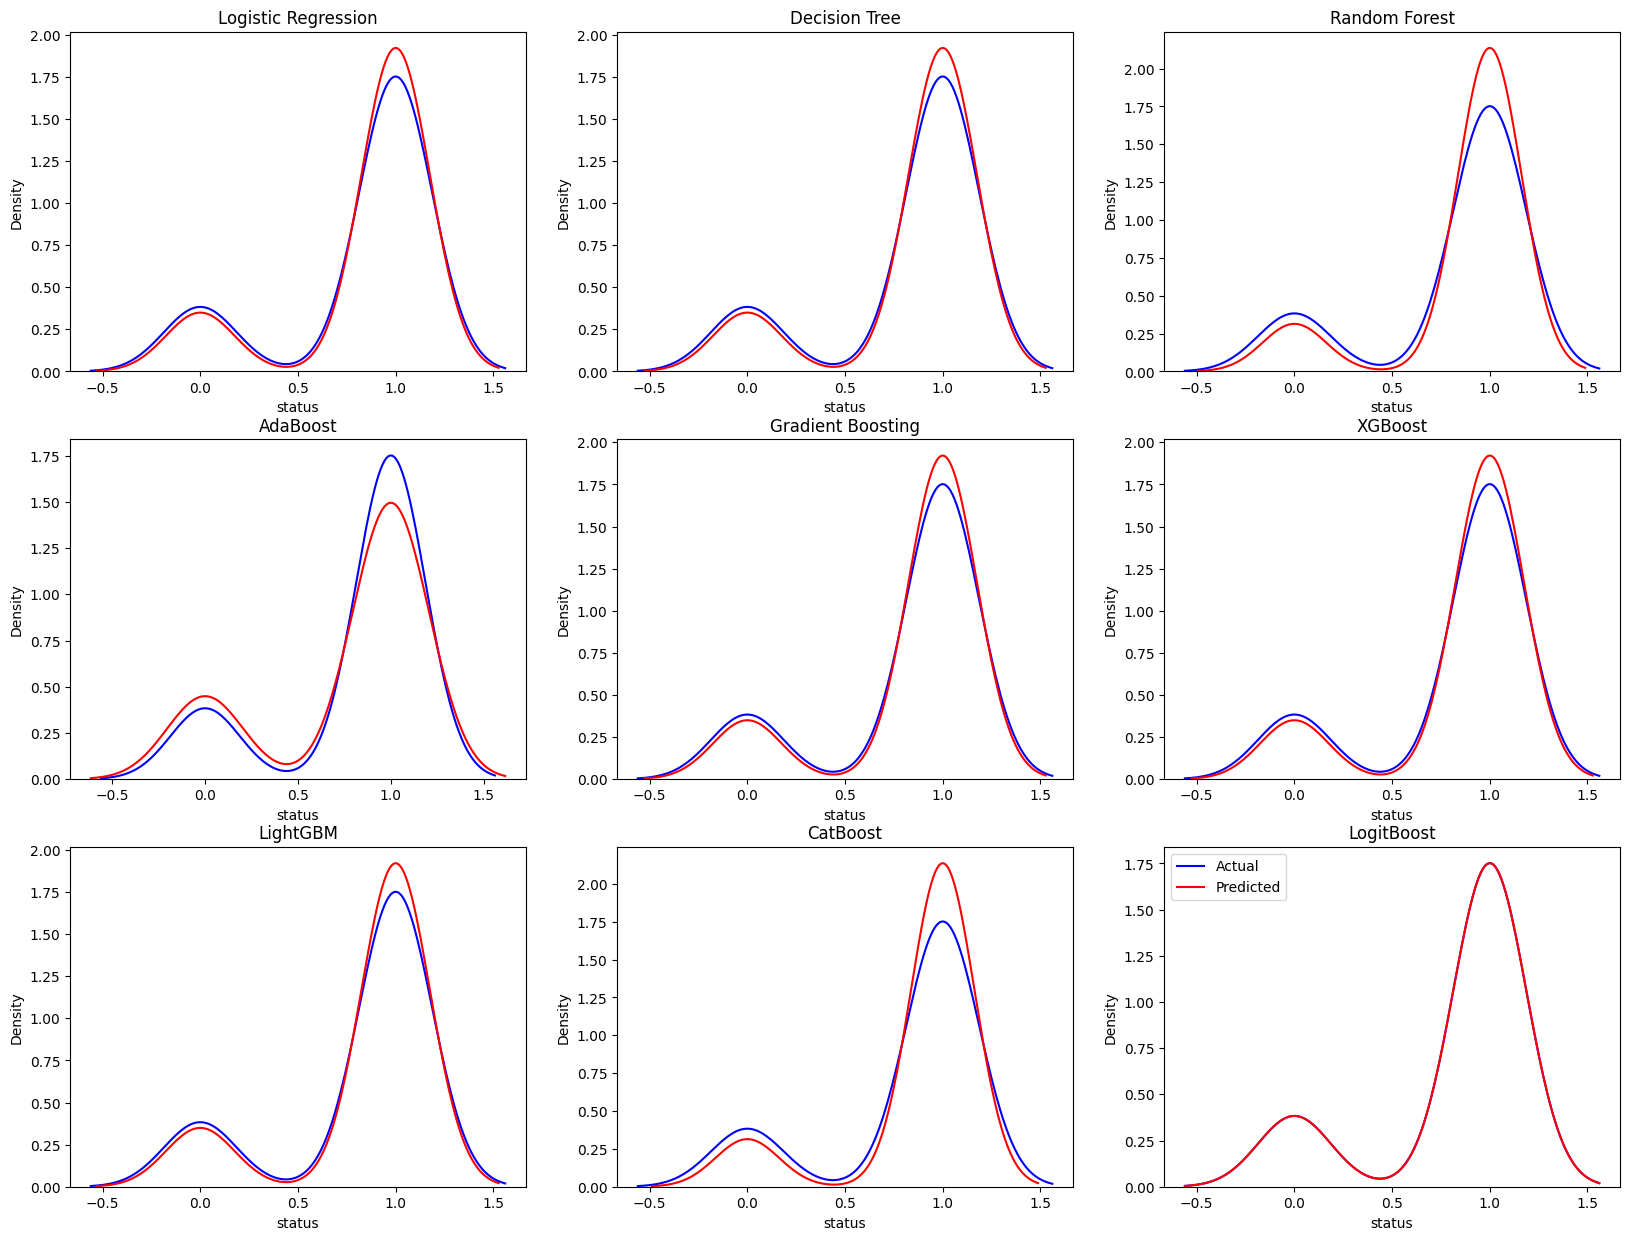

In [ ]:
# Plotting the distributions
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

model_names = list(models.keys())

for i, name in enumerate(model_names):
    sns.kdeplot(y_test, ax=ax[i//3, i%3], label='Actual', color='blue')
    sns.kdeplot(predictions[name], ax=ax[i//3, i%3], label='Predicted', color='red')
    ax[i//3, i%3].set_title(name)

plt.legend()
plt.show()

##Conclusion

The spread1 and PPE features have the highest positive correlation with the status variable. This suggests that as the values of these features increase, the likelihood of a subject being diagnosed with Parkinson's disease also increases.

Other features like spread2, MDVP, MDVP, and MDVP(dB) also show positive correlations, indicating they may be important indicators of Parkinson's disease.

MDVP(Hz) and MDVP(Hz) have negative correlations with the status variable, implying that higher values of these features are associated with a lower likelihood of Parkinson's disease. HNR (Harmonics-to-Noise Ratio) also shows a negative correlation, which suggests that a higher HNR (a measure of voice quality) is associated with healthier subjects.


Random Forest and CatBoost are the top-performing models, both achieving the highest accuracy, precision, and F1 score. They provide a strong balance between precision (low false positives) and recall (high true positives).